### Causal trees interpretation

In [1]:
import pandas as pd
import numpy as np
import multiprocessing as mp
np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap 

import causalml
from causalml.metrics import plot_gain, plot_qini, qini_score
from causalml.dataset import synthetic_data
from causalml.inference.tree import plot_dist_tree_leaves_values, get_tree_leaves_mask
from causalml.inference.tree import CausalRandomForestRegressor, CausalTreeRegressor
from causalml.inference.tree.utils import timeit

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [2]:
causalml.__version__

'0.13.0'

In [3]:
# Simulate randomized trial: mode=2
y, X, w, tau, b, e = synthetic_data(mode=2, n=2000, p=10, sigma=3.0)

df = pd.DataFrame(X)
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
df.columns = feature_names
df['outcome'] = y
df['treatment'] = w
df['treatment_effect'] = tau

In [4]:
# Split data to training and testing samples for model validation
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)
n_train, n_test = df_train.shape[0], df_test.shape[0]

X_train, y_train = df_train[feature_names], df_train['outcome'].values
X_test, y_test = df_test[feature_names], df_test['outcome'].values
treatment_train, treatment_test = df_train['treatment'].values, df_test['treatment'].values
effect_test = df_test['treatment_effect'].values

observation = X_test.loc[[0]]

#### CausalTreeRegressor

In [5]:
ctree = CausalTreeRegressor()
ctree.fit(X=X_train.values, y=y_train, treatment=treatment_train)

CausalTreeRegressor()

#### CausalRandomForestRegressor

In [6]:
crforest = CausalRandomForestRegressor(criterion="causal_mse",
                                  min_samples_leaf=200,
                                  control_name=0,
                                  n_estimators=50,
                                  n_jobs=mp.cpu_count() - 1)
crforest.fit(X=X_train, y=y_train, treatment=treatment_train)

CausalRandomForestRegressor(min_samples_leaf=200, n_estimators=50, n_jobs=11)

### Impurity-based feature importance

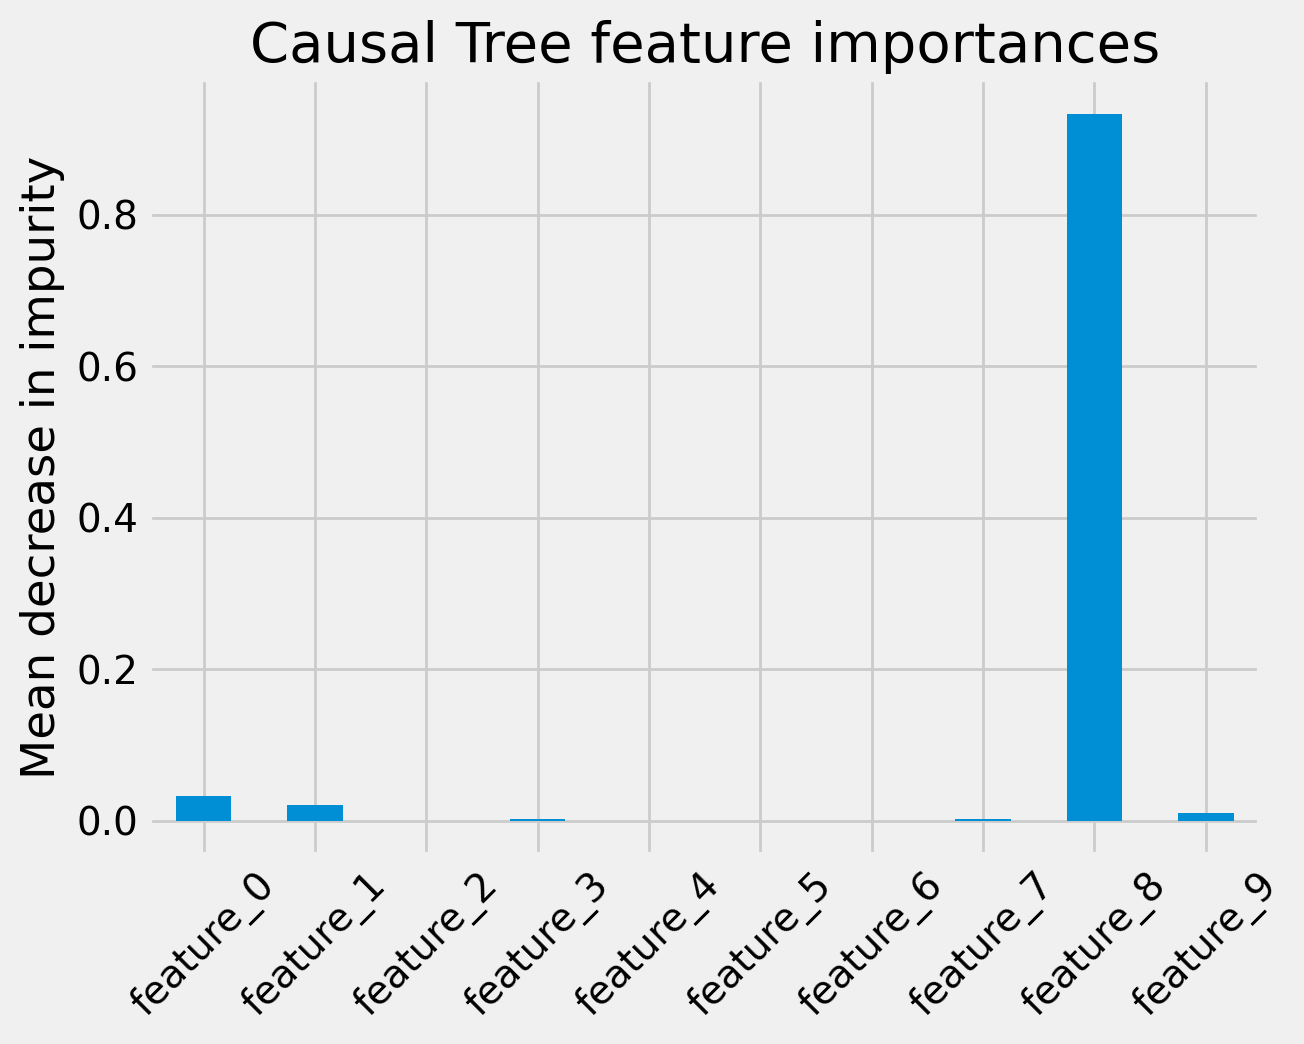

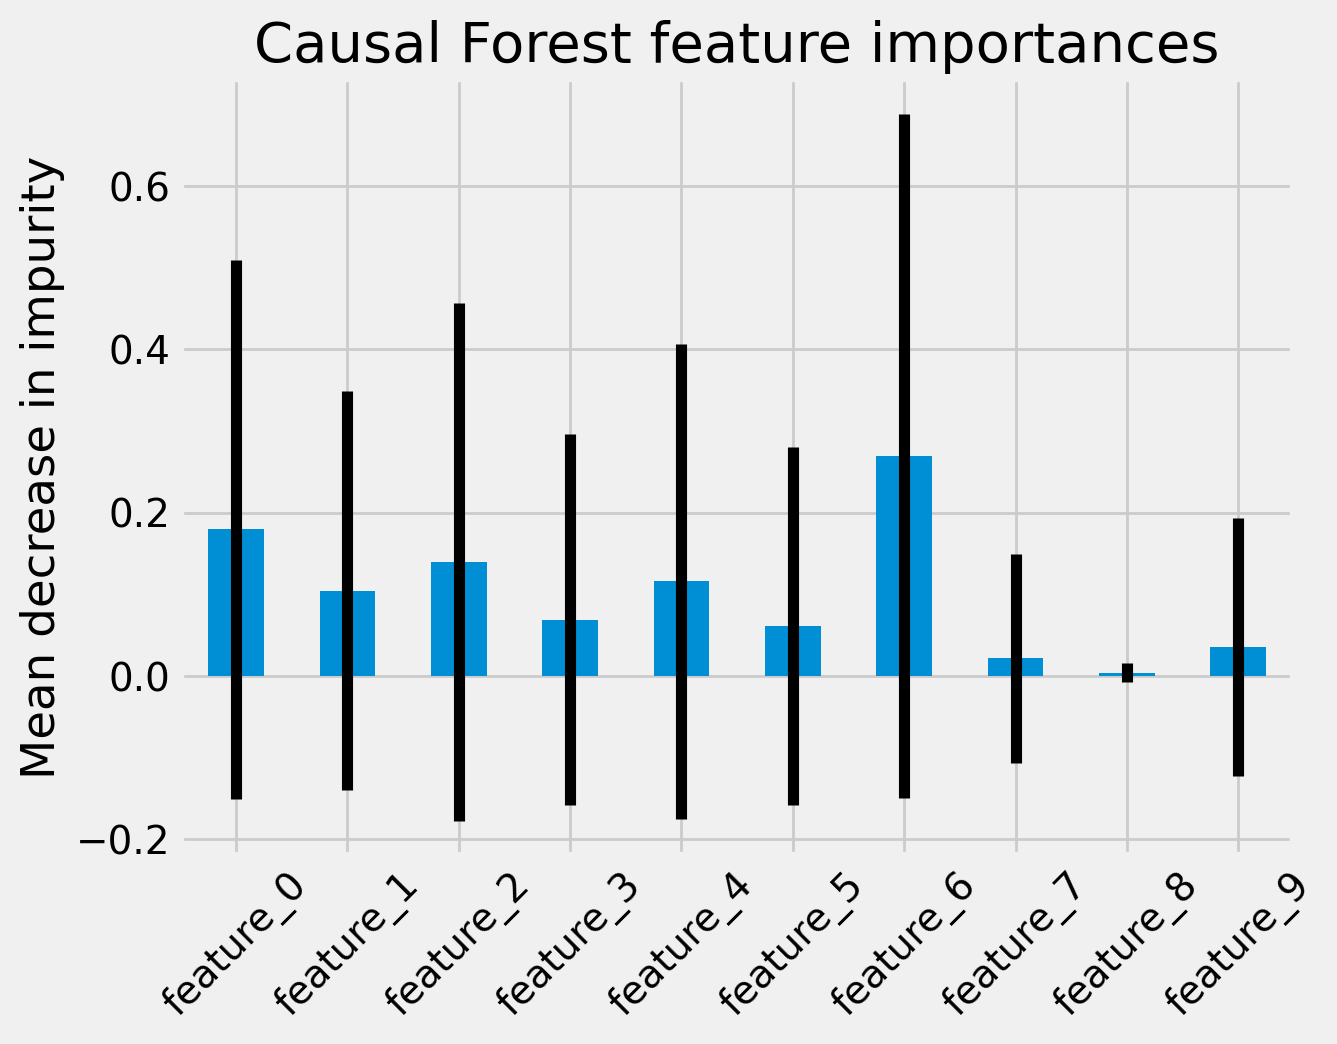

In [7]:
df_importances = pd.DataFrame({'tree': ctree.feature_importances_, 
                               'forest': crforest.feature_importances_,
                               'feature': feature_names
                              })
forest_std = np.std([tree.feature_importances_ for tree in crforest.estimators_], axis=0)

fig, ax = plt.subplots()
df_importances['tree'].plot.bar(ax=ax)
ax.set_title("Causal Tree feature importances")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feature_names, rotation=45)
plt.show()

fig, ax = plt.subplots()
df_importances['forest'].plot.bar(yerr=forest_std, ax=ax)
ax.set_title("Causal Forest feature importances")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feature_names, rotation=45)
plt.show()

### Permutation importance

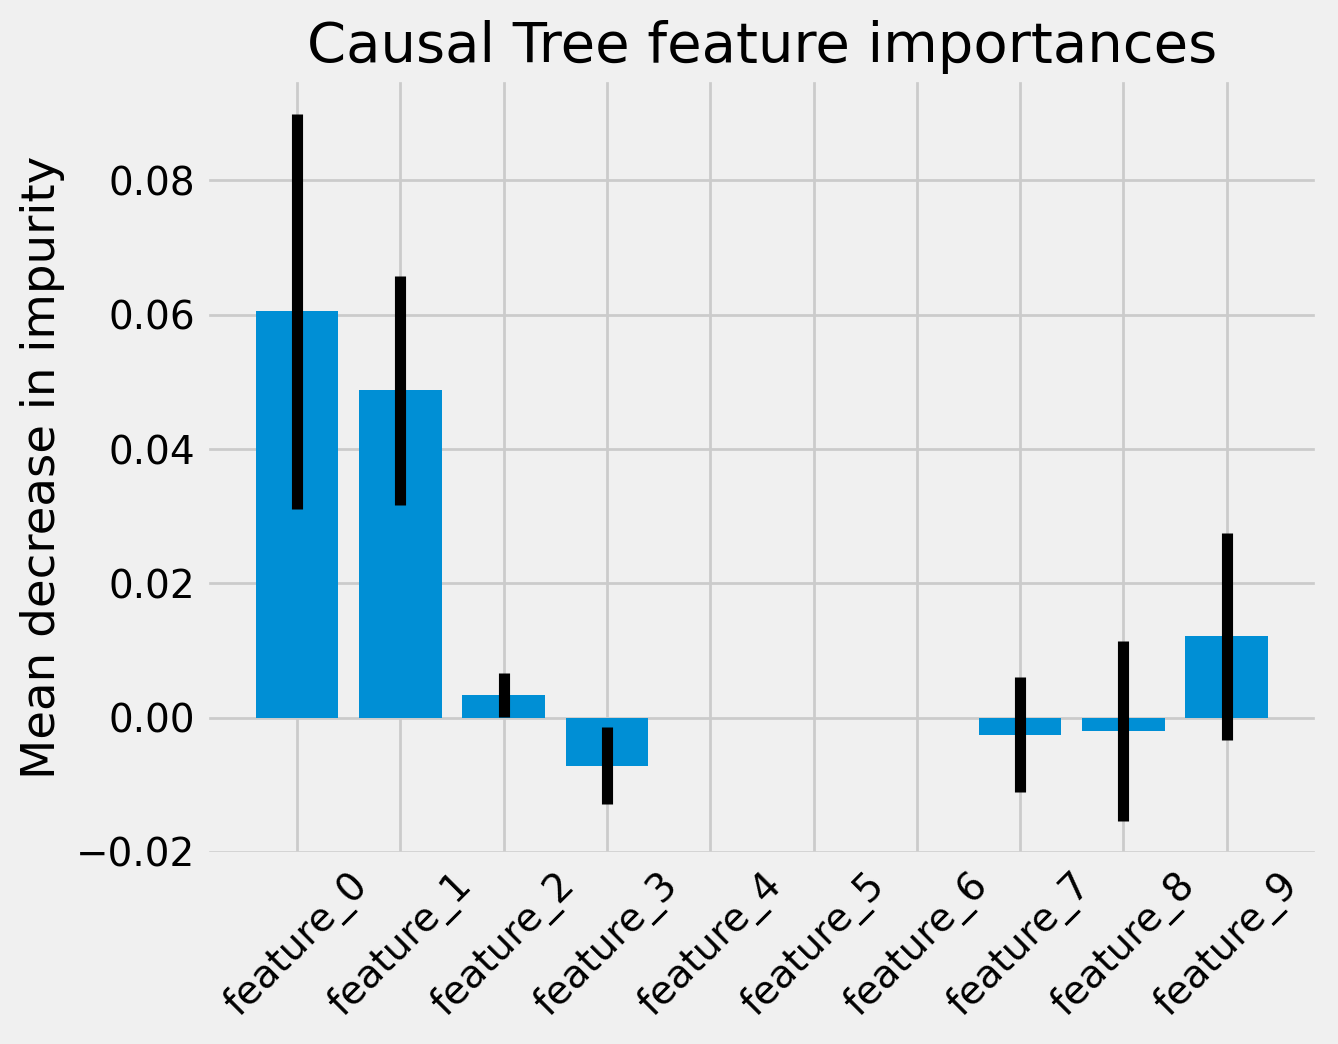

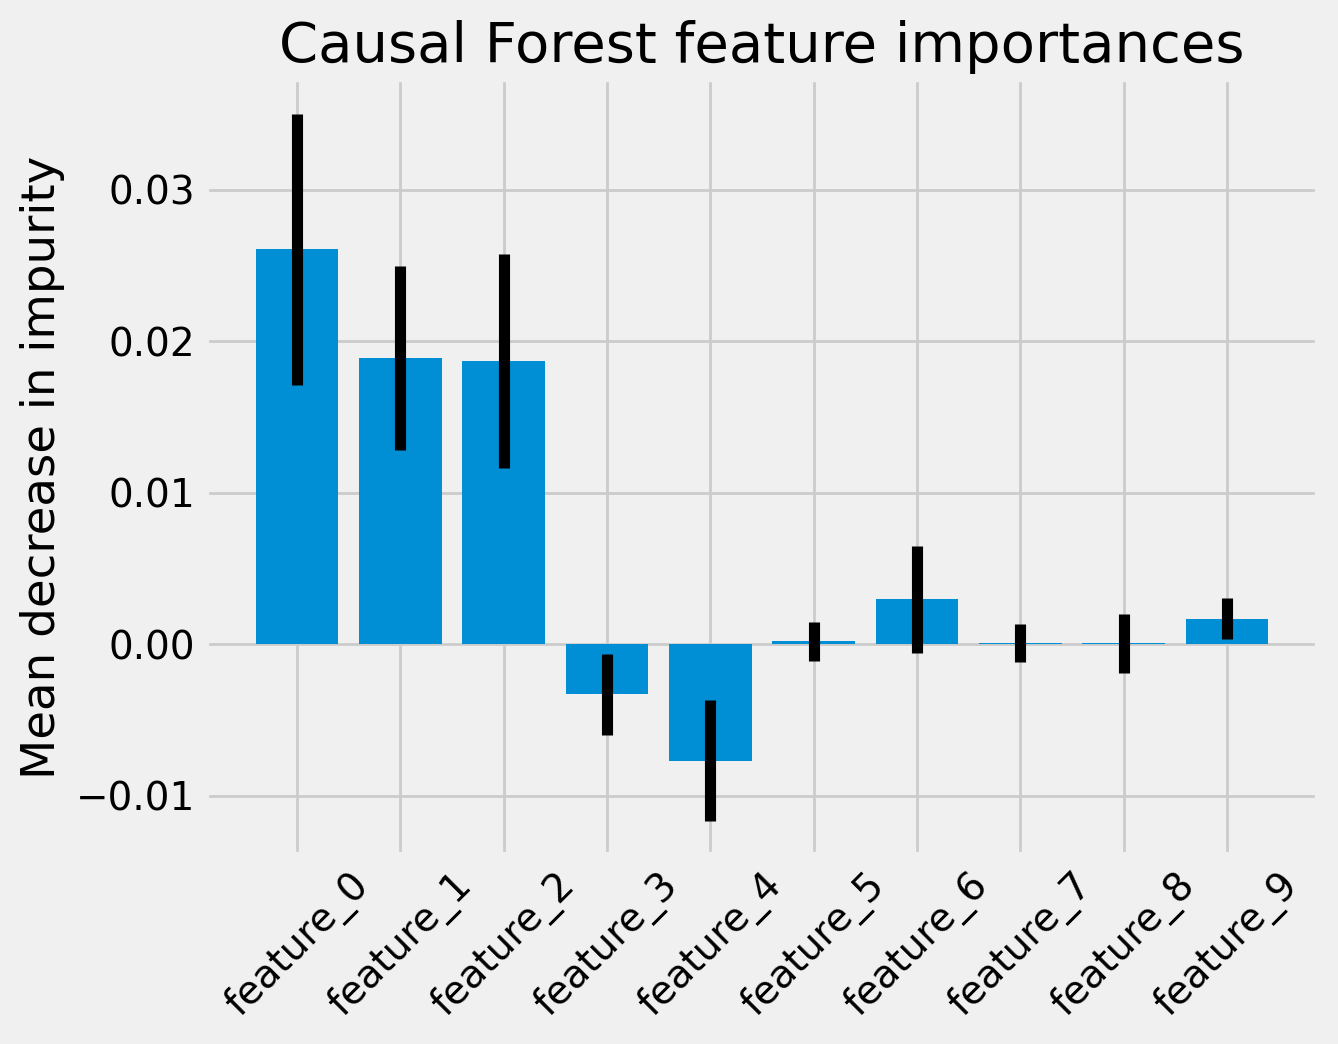

In [8]:
for name, model in zip(('Causal Tree', 'Causal Forest'), (ctree, crforest)):
    
    imp = permutation_importance(model, X_test, y_test,
                                 n_repeats=50,
                                 random_state=0)
    
    fig, ax = plt.subplots()
    ax.set_title(f"{name} feature importances")
    ax.set_ylabel("Mean decrease in impurity")
    plt.bar(feature_names, imp['importances_mean'], yerr=imp['importances_std'])
    ax.set_xticklabels(feature_names, rotation=45)
    plt.show()

### SHAP values

Details: https://shap.readthedocs.io/en/latest/index.html

In [9]:
# The error "Model type not yet supported by TreeExplainer" will occur if causalml support PR is not closed yet.
# Temporal solution is this fork:
# git clone https://github.com/alexander-pv/shap.git && cd shap
# pip install .
tree_explainer = shap.TreeExplainer(ctree)
shap.initjs()
shap_values = tree_explainer.shap_values(observation)
shap.force_plot(tree_explainer.expected_value[0],
                shap_values[0],
                observation)

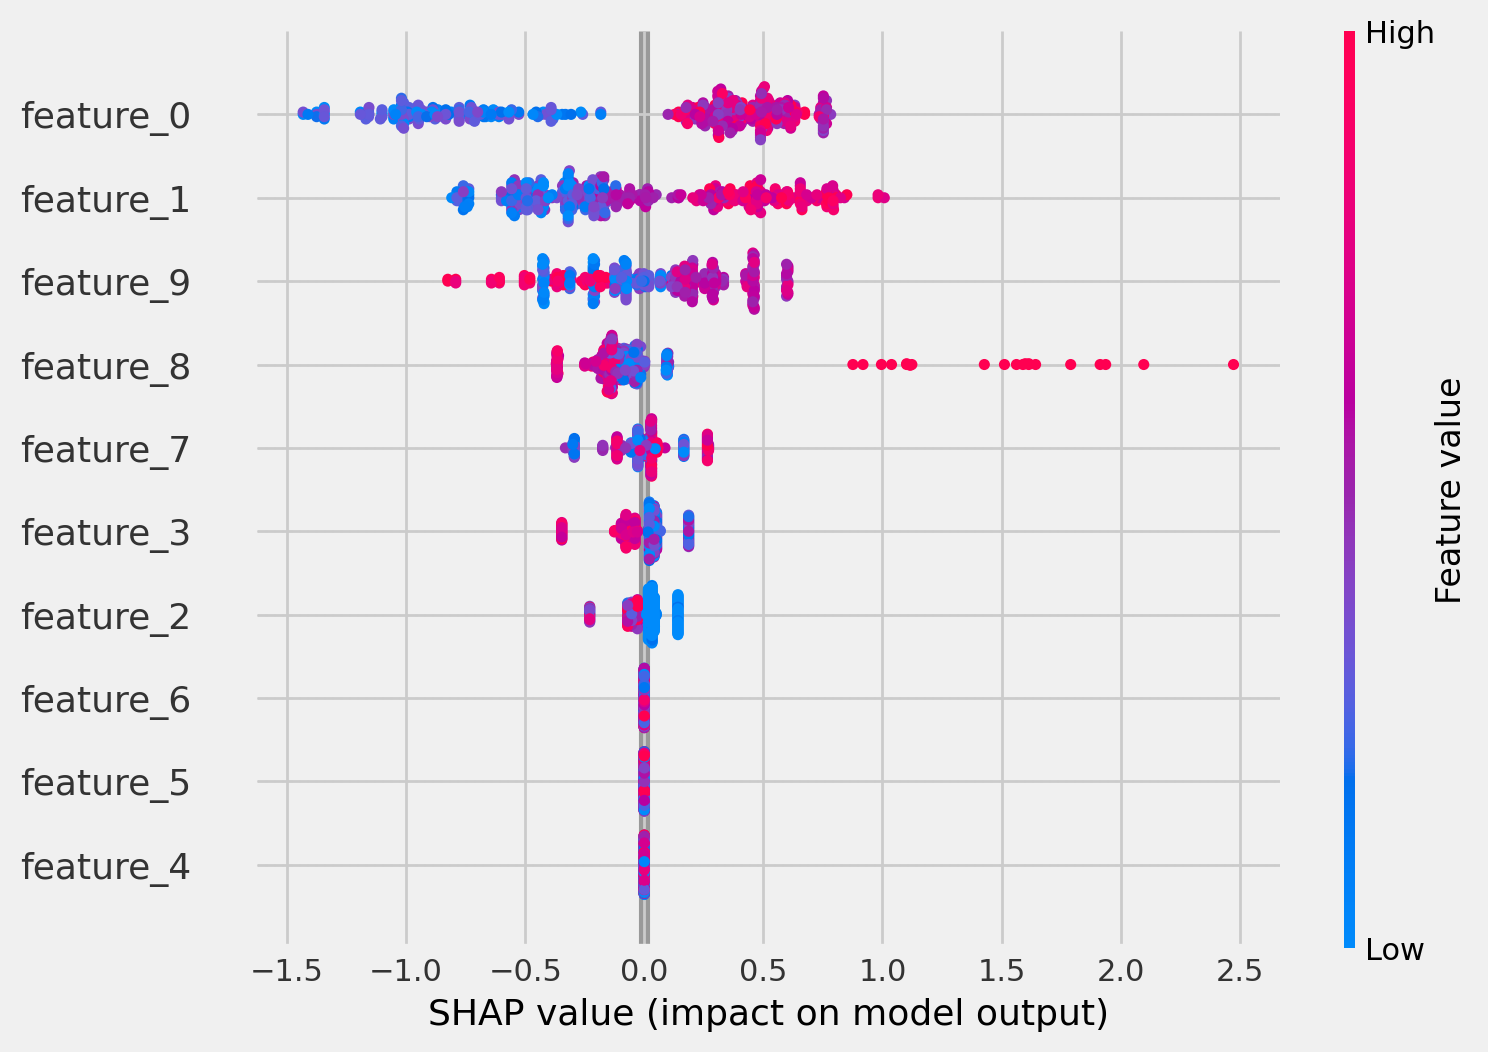

In [10]:
shap.summary_plot(tree_explainer.shap_values(X_test), X_test)

In [11]:
cforest_explainer = shap.TreeExplainer(crforest)
shap.initjs()
shap_values = cforest_explainer.shap_values(observation)
shap.force_plot(cforest_explainer.expected_value[0],
                shap_values[0],
                observation)

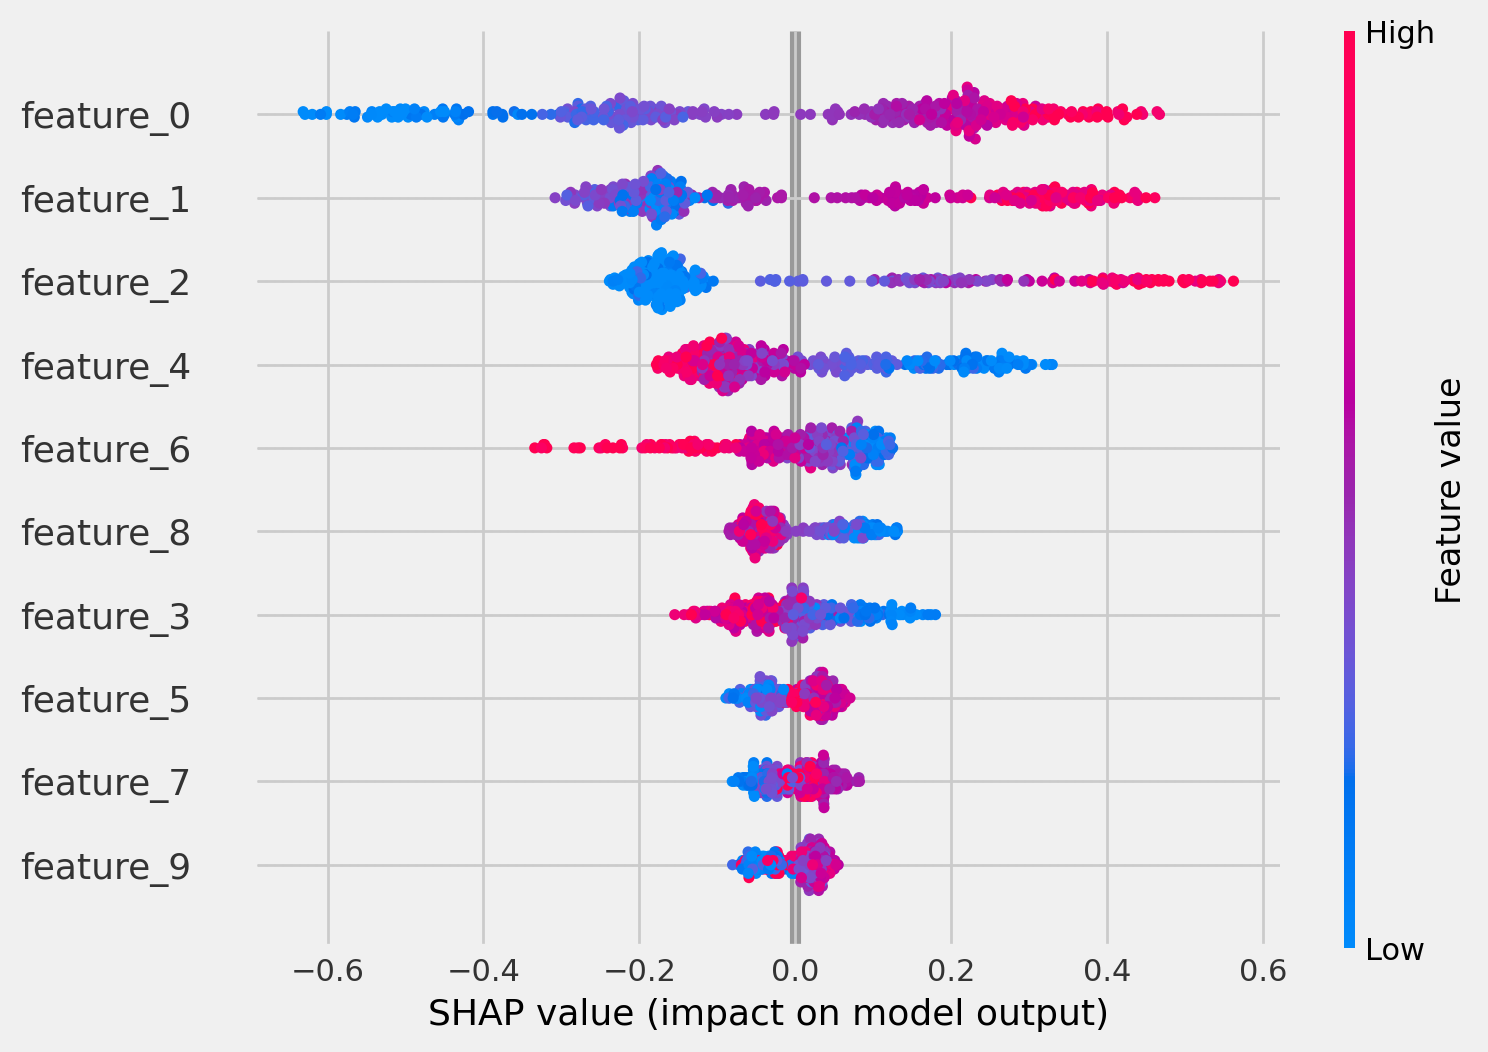

In [12]:
shap.summary_plot(cforest_explainer.shap_values(X_test), X_test)

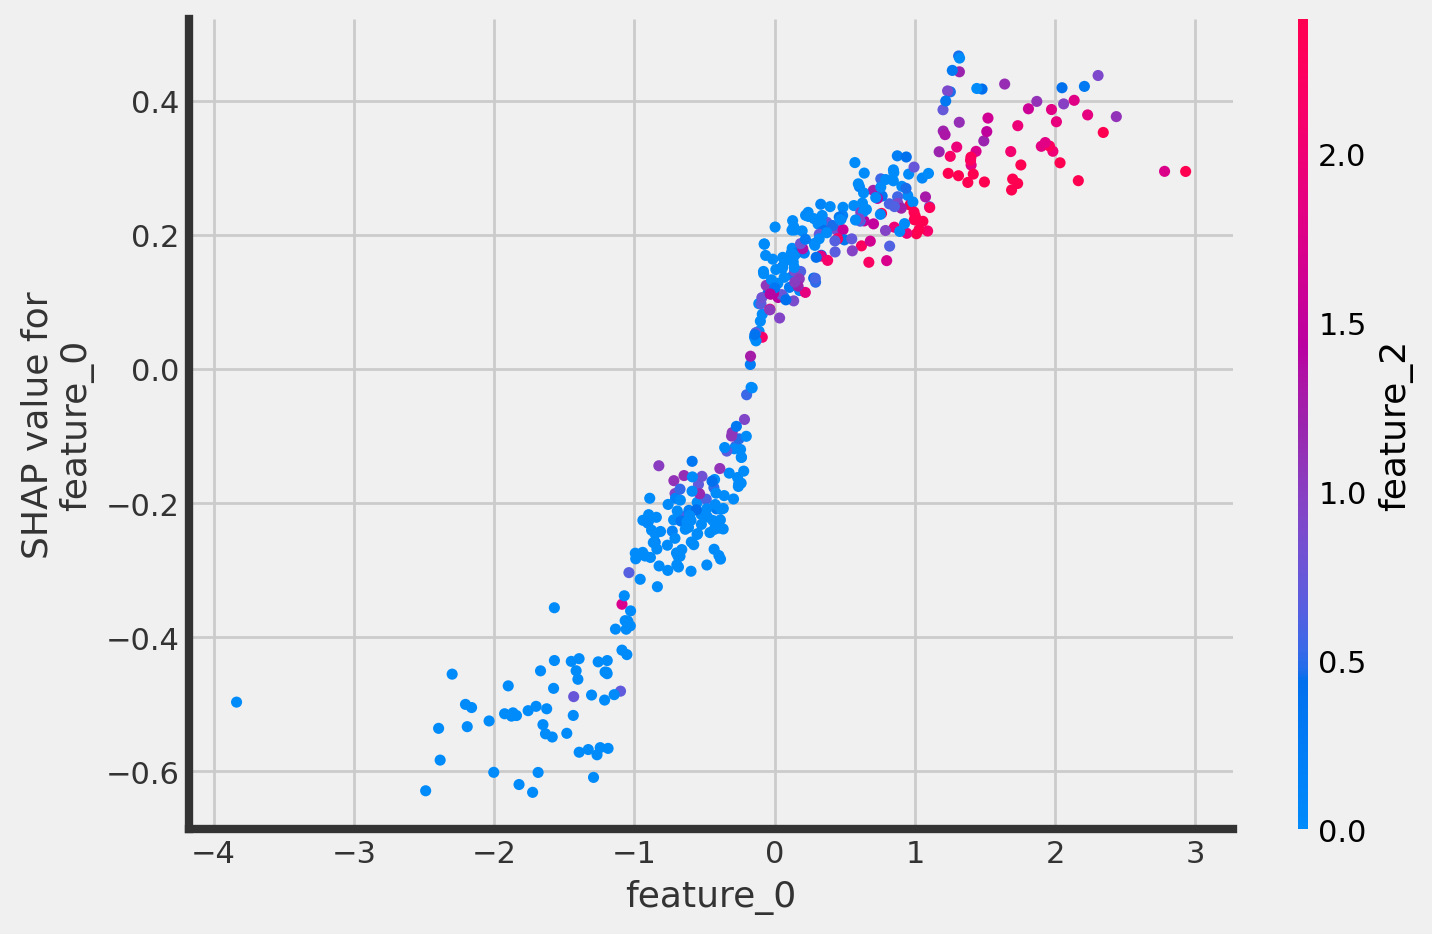

In [13]:
shap.dependence_plot("feature_0", 
                     cforest_explainer.shap_values(X_test), 
                     X_test, 
                     interaction_index="feature_2")

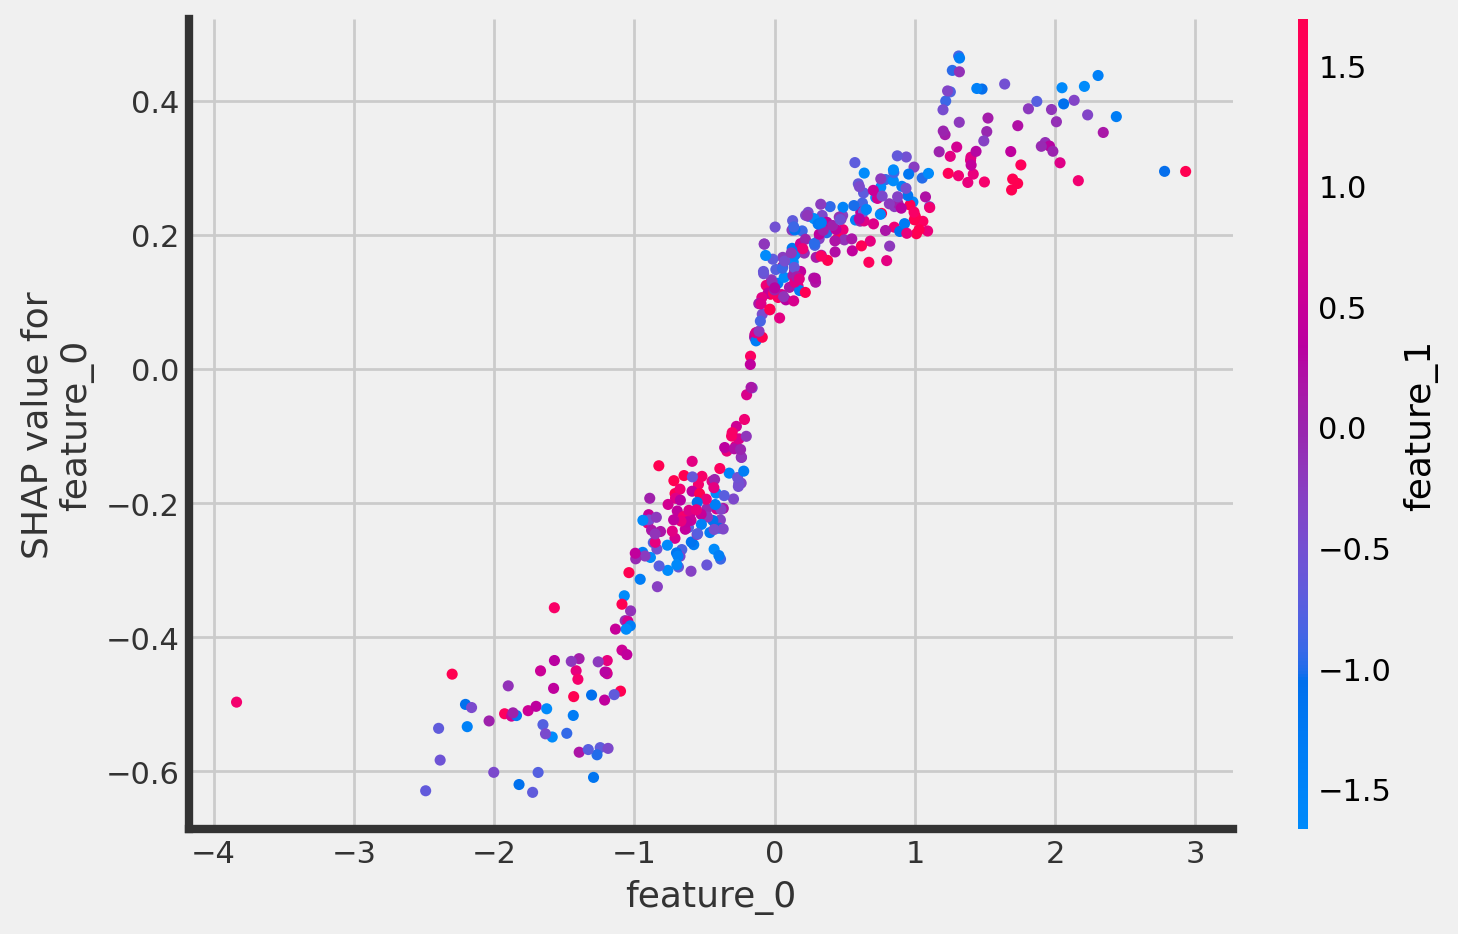

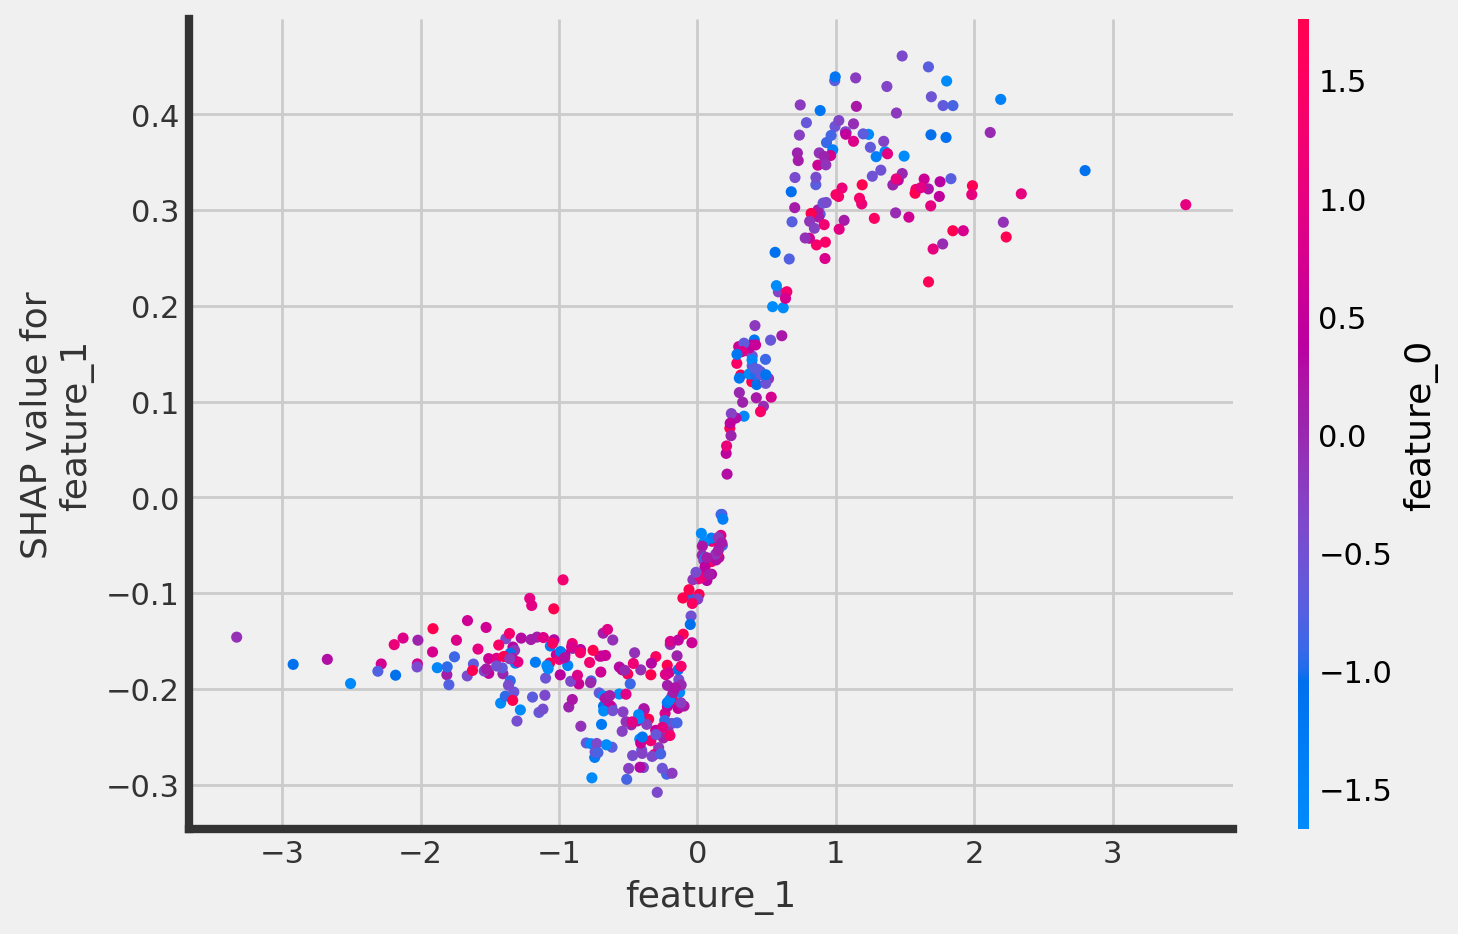

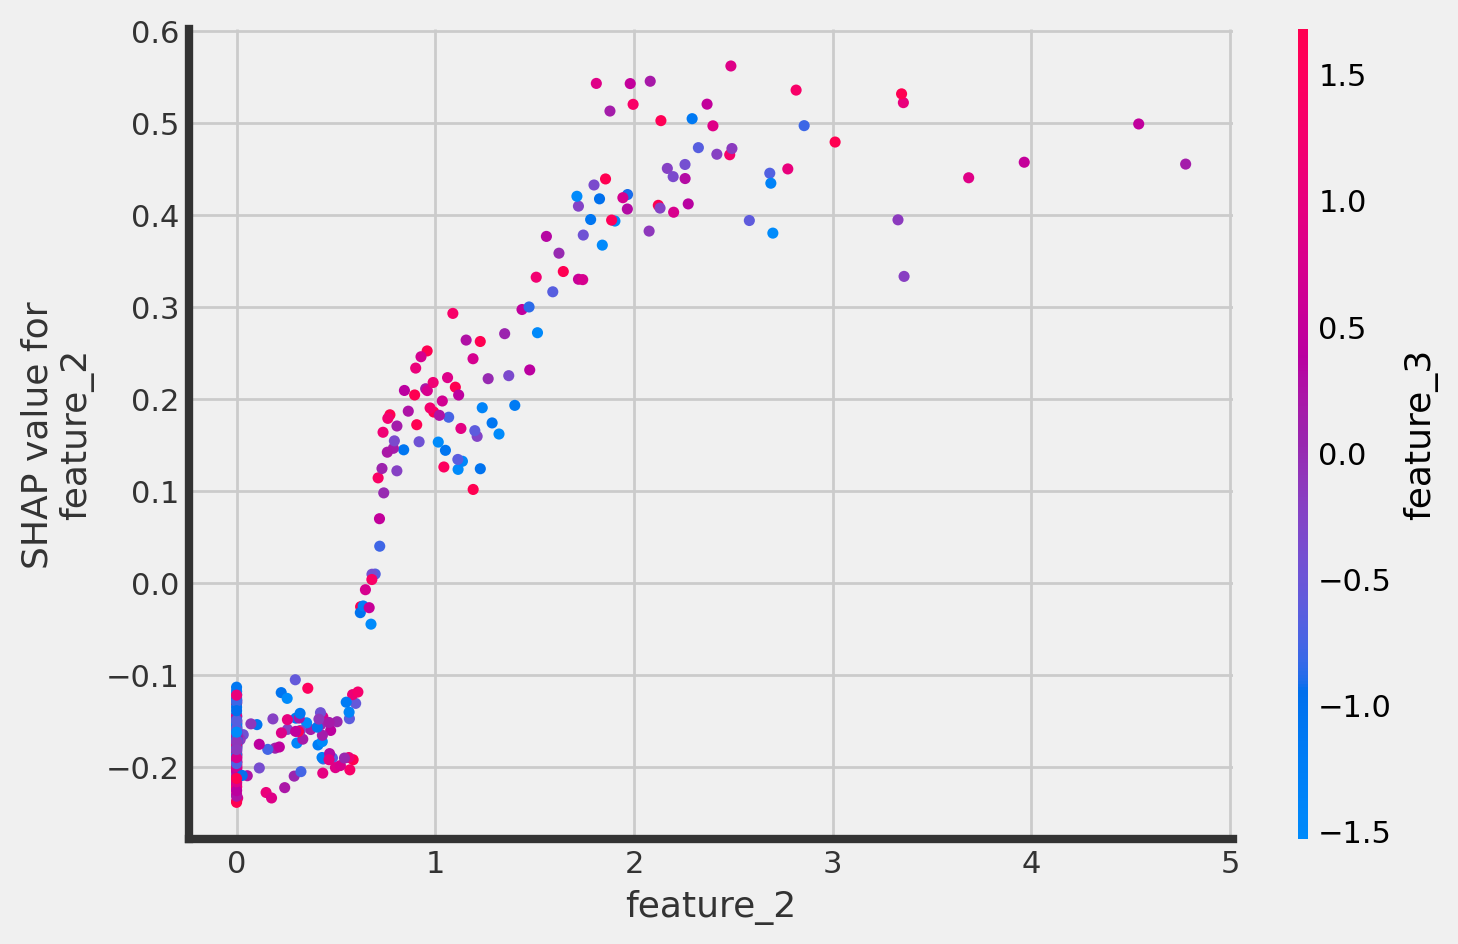

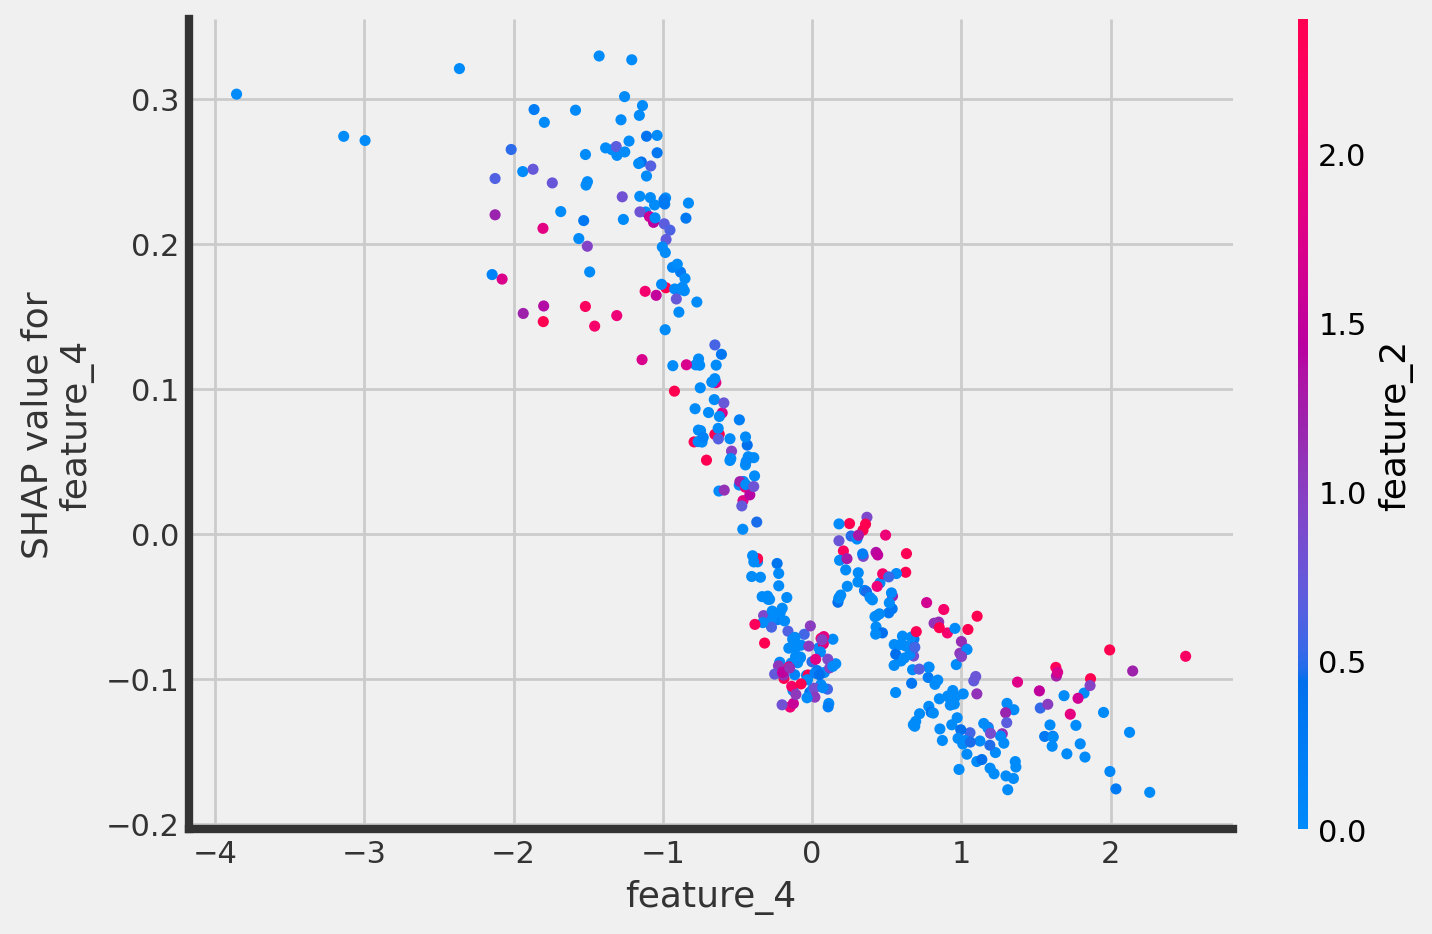

In [14]:
# Sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
shap_values = cforest_explainer.shap_values(X_test)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# Make SHAP plots of the three most important features
for i in range(4):
    shap.dependence_plot(top_inds[i], shap_values, X_test)